In [1]:
# Configuration
MODEL_NAME = "ViT-B-32"
PRETRAINED_DATASET = "laion2b_s34b_b79k"
DEVICE_PREFERENCE = "mps"  # options: "cuda", "mps", "cpu"
SEED = 42

# Dataset configuration
RUN_SPLITS = ["test"]   # later: ["train", "val", "test"]
LIMIT_IMAGES = None      # 100 subset for quick check; set None for full split
BATCH_SIZE = 32
K_VALUES = (1, 5, 10)


In [3]:
import os
import sys
from pathlib import Path

from utils import *
from typing import List, Dict, Any, cast
import json, csv, time

import matplotlib.pyplot as plt
import numpy as np
import torch

PROJECT_ROOT = Path(os.getcwd()).resolve()
OUTPUT_DIR = str((PROJECT_ROOT / "output").resolve())
ensure_dir(OUTPUT_DIR)

device = select_torch_device(DEVICE_PREFERENCE)
set_all_seeds(SEED)

device


device(type='mps')

### prepare dataset

In [4]:
# Set default dataset paths (can be overridden above)

ENTITIES_ROOT = "data/flickr30k/flickr30k_entities-master"

SPLIT = 'test'

ANNOTATIONS_JSON =  str((Path(OUTPUT_DIR) / f"flickr30k_annotations_{SPLIT}.json").resolve())
IMAGES_ROOT = "data/flickr30k/flickr30k-images"

print({"ANNOTATIONS_JSON": ANNOTATIONS_JSON, "IMAGES_ROOT": IMAGES_ROOT})

{'ANNOTATIONS_JSON': '/Users/apple/grad_material/2025 fall/comp 545/final/output/flickr30k_annotations_test.json', 'IMAGES_ROOT': 'data/flickr30k/flickr30k-images'}


In [5]:
# if annotations json missing
# Build from Flickr30k Entities


if 1:
    for split in ['test', 'train', 'val']:
        eroot = Path(ENTITIES_ROOT).expanduser().resolve()
        sys.path.append(str(eroot))
        from flickr30k_entities_utils import get_sentence_data  # type: ignore
        ids = (eroot / f"{split}.txt").read_text().splitlines()
        sent_dir = eroot / "annotations" / "Sentences"
        anns = []
        
        for img_id in ids:
            if not img_id:
                continue
            sfile = sent_dir / f"{img_id}.txt"
            data = get_sentence_data(str(sfile))
            caps = [d.get("sentence", "").strip() for d in data if d.get("sentence")]
            anns.append({"image": f"{img_id}.jpg", "captions": caps})

        import json as _json
        out_path_json = (Path(OUTPUT_DIR) / f"flickr30k_annotations_{split}.json")
        out_path_json.parent.mkdir(parents=True, exist_ok=True)
        with out_path_json.open("w", encoding="utf-8") as f:
            _json.dump({"annotations": anns}, f, ensure_ascii=False)
        print(f"Saved {out_path_json}")


Saved /Users/apple/grad_material/2025 fall/comp 545/final/output/flickr30k_annotations_test.json
Saved /Users/apple/grad_material/2025 fall/comp 545/final/output/flickr30k_annotations_train.json
Saved /Users/apple/grad_material/2025 fall/comp 545/final/output/flickr30k_annotations_val.json


### prepare model and encoder

In [6]:
# create open_clip model

import open_clip

model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME,
    pretrained=PRETRAINED_DATASET,
    device=device,
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
_ = model.eval()


In [7]:
# load dataset list

ann_path = Path(ANNOTATIONS_JSON).expanduser().resolve()
img_root = Path(IMAGES_ROOT).expanduser().resolve()

dataset = load_flickr30k_karpathy_json(
    annotations_path=ann_path,
    images_root=img_root,
    split=SPLIT,
    limit=LIMIT_IMAGES,
)

num_images = len(dataset)
ds_typed: List[Dict[str, Any]] = cast(List[Dict[str, Any]], dataset)
num_captions = sum(len(cast(List[str], d.get("captions", []))) for d in ds_typed)

print({"images": num_images, "captions": num_captions})


{'images': 1000, 'captions': 5000}


In [23]:
# encode embeddings (single run helper)
def run_encode_eval(split_tag: str, chunk_words, chunk_stride, pooling):
    emb_local = encode_openclip_embeddings(
        dataset=dataset,
        preprocess=preprocess,
        tokenizer=tokenizer,
        model=model,
        device=device,
        batch_size=BATCH_SIZE,
        text_chunk_words=int(chunk_words) if chunk_words else None,
        text_chunk_stride=int(chunk_stride) if chunk_stride else None,
        text_pooling=str(pooling),
        progress=True,
        progress_desc=f"{split_tag}|{pooling or 'base'}",
        chunk_threshold_tokens=32,
    )
    img_shape_l = tuple(np.array(emb_local["image_embeddings"]).shape)
    cap_shape_l = tuple(np.array(emb_local["caption_embeddings"]).shape)
    print({"image_embeddings": img_shape_l, "caption_embeddings": cap_shape_l})

    img_emb_l = np.asarray(emb_local["image_embeddings"], dtype=np.float32)
    cap_emb_l = np.asarray(emb_local["caption_embeddings"], dtype=np.float32)
    cap2img_l = np.asarray(emb_local["caption_to_image_index"], dtype=np.int64)
    img2cap_l = cast(List[List[int]], emb_local["image_to_caption_indices"])

    r_t2i_l = recall_at_k_text_to_image(img_emb_l, cap_emb_l, cap2img_l, ks=K_VALUES)
    r_i2t_l = recall_at_k_image_to_text(img_emb_l, cap_emb_l, img2cap_l, ks=K_VALUES)
    print("Text-to-Image Recall@K:", {k: round(v * 100, 3) for k, v in r_t2i_l.items()})
    print("Image-to-Text Recall@K:", {k: round(v * 100, 3) for k, v in r_i2t_l.items()})

    # save metrics
    import csv, time

    run_tag = f"{split_tag}_cw{int(chunk_words or 0)}_cs{int(chunk_stride or 0)}_{pooling or 'base'}"

    csv_path = str(Path(OUTPUT_DIR) / f"metrics_{run_tag}.csv")
    results = {
        "model": MODEL_NAME,
        "pretrained": PRETRAINED_DATASET,
        "split": split_tag,
        "limit": -1 if LIMIT_IMAGES is None else int(LIMIT_IMAGES),
        "batch_size": int(BATCH_SIZE),
        "device": str(device),
        "images": int(img_shape_l[0]),
        "captions": int(cap_shape_l[0]),
        "t2i_R@1": float(r_t2i_l.get(1, 0.0)),
        "t2i_R@5": float(r_t2i_l.get(5, 0.0)),
        "t2i_R@10": float(r_t2i_l.get(10, 0.0)),
        "i2t_R@1": float(r_i2t_l.get(1, 0.0)),
        "i2t_R@5": float(r_i2t_l.get(5, 0.0)),
        "i2t_R@10": float(r_i2t_l.get(10, 0.0)),
        "timestamp": int(time.time()),
        "text_chunk_words": int(chunk_words or 0),
        "text_chunk_stride": int(chunk_stride or 0),
        "text_pooling": str(pooling or "base"),
    }

    with open(csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=list(results.keys()))
        if not Path(csv_path).exists():
            writer.writeheader()
        writer.writerow(results)
    print({"saved csv": csv_path})

    return emb_local, r_t2i_l, r_i2t_l

In [ ]:
# primary run
emb, r_t2i, r_i2t = run_encode_eval(SPLIT, 0, 0, 'mean')

test|mean:   0%|          | 0/32 [00:00<?, ?it/s]

test|mean:   0%|          | 0/79 [00:00<?, ?it/s]

{'image_embeddings': (1000, 512), 'caption_embeddings': (5000, 512)}
Text-to-Image Recall@K: {1: 69.76, 5: 89.68, 10: 93.76}
Image-to-Text Recall@K: {1: 84.5, 5: 96.0, 10: 98.5}
{'saved csv': '/Users/apple/grad_material/2025 fall/comp 545/final/output/metrics_test_cw0_cs0_mean.csv'}


### primary result

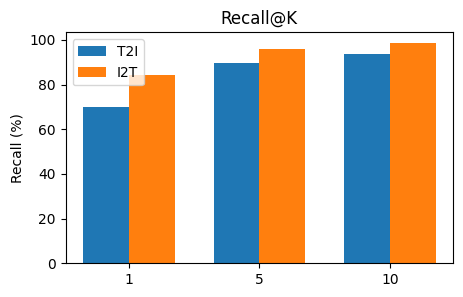

In [10]:

ks = [str(k) for k in K_VALUES]
t2i_vals = [r_t2i[k] * 100 for k in K_VALUES]
i2t_vals = [r_i2t[k] * 100 for k in K_VALUES]
w = 0.35
idx = np.arange(len(K_VALUES))
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(idx - w / 2, t2i_vals, width=w, label="T2I")
ax.bar(idx + w / 2, i2t_vals, width=w, label="I2T")
ax.set_xticks(idx)
ax.set_xticklabels(ks)
ax.set_ylabel("Recall (%)")
ax.set_title("Recall@K")
ax.legend()
plt.show()


In [11]:
img_emb = np.asarray(emb["image_embeddings"], dtype=np.float32)
cap_emb = np.asarray(emb["caption_embeddings"], dtype=np.float32)
cap2img = np.asarray(emb["caption_to_image_index"], dtype=np.int64)
img2cap = cast(List[List[int]], emb["image_to_caption_indices"])

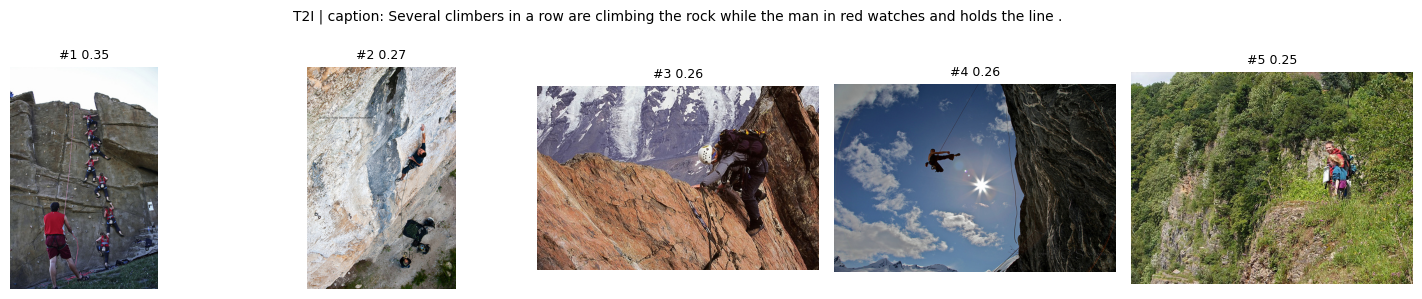

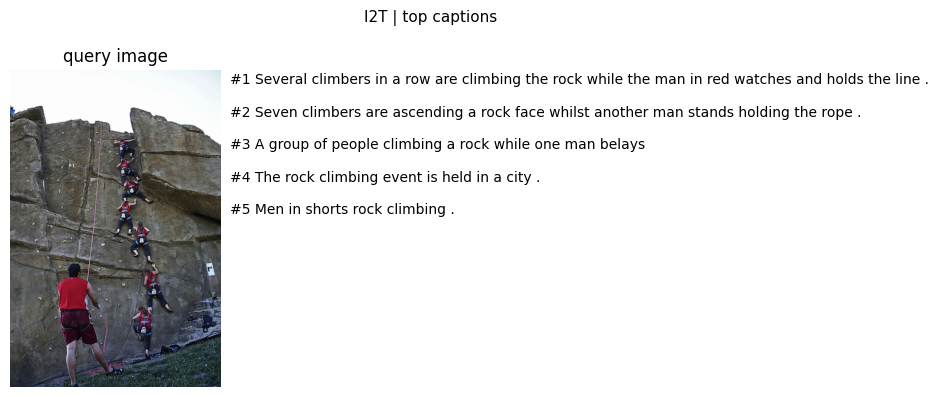

In [12]:
# sample viz config
TOPK_VIS = 5
SAMPLE_CAPTION_INDEX = 0
SAMPLE_IMAGE_INDEX = 0

# visualize one caption->topK images and one image->topK captions
from PIL import Image

# flatten captions to align with cap_emb order
caps_flat: List[str] = []
for item in ds_typed:
    caps_flat.extend(cast(List[str], item.get("captions", [])))
image_paths: List[str] = [str(d["image_path"]) for d in ds_typed]

# caption -> topK images
sim_t2i = cap_emb @ img_emb.T
cidx = int(SAMPLE_CAPTION_INDEX)
top_idx = np.argsort(-sim_t2i[cidx])[:TOPK_VIS]
fig, axes = plt.subplots(1, TOPK_VIS, figsize=(3 * TOPK_VIS, 3))
for j, ax in enumerate(np.atleast_1d(axes)):
    img = Image.open(image_paths[top_idx[j]]).convert("RGB")
    ax.imshow(img)
    score = float(sim_t2i[cidx, top_idx[j]])
    ax.set_title(f"#{j+1} {score:.2f}", fontsize=9)
    ax.axis("off")
fig.suptitle(f"T2I | caption: {caps_flat[cidx]}", fontsize=10)
fig.tight_layout()

plt.show()

# image -> topK captions (show query image + text list)
sim_i2t = img_emb @ cap_emb.T
iidx = int(SAMPLE_IMAGE_INDEX)
top_cap_idx = np.argsort(-sim_i2t[iidx])[:TOPK_VIS]
fig, (ax_img, ax_txt) = plt.subplots(1, 2, figsize=(10, 4))
img = Image.open(image_paths[iidx]).convert("RGB")
ax_img.imshow(img)
ax_img.set_title("query image")
ax_img.axis("off")
lines = [f"#{k+1} {caps_flat[idx]}" for k, idx in enumerate(top_cap_idx)]
ax_txt.axis("off")
ax_txt.text(0.01, 0.99, "\n\n".join(lines), va="top", fontsize=10)
fig.suptitle("I2T | top captions", fontsize=11)
fig.tight_layout()

plt.show()

### add text adapter

In [13]:
def finetune_text_adapter(emb_dict, steps=300, lr=1e-3, batch=256, temp=0.07, hidden=0):
    img_e = np.asarray(emb_dict["image_embeddings"], dtype=np.float32)
    cap_e = np.asarray(emb_dict["caption_embeddings"], dtype=np.float32)
    c2i = np.asarray(emb_dict["caption_to_image_index"], dtype=np.int64)
    out = train_text_adapter_infonce(
        image_embeddings=img_e,
        caption_embeddings=cap_e,
        caption_to_image_index=c2i,
        steps=int(steps),
        batch_size=int(batch),
        lr=float(lr),
        temperature=float(temp),
        hidden_dim=int(hidden),
        device=device,
        progress=True,
    )
    return out

In [ ]:
# quick toggle to compare baseline vs chunking (disabled by default)
if 1:
    emb_base, r_t2i_b, r_i2t_b = run_encode_eval(SPLIT, 0, 0, "base")
    emb_chunk, r_t2i_c, r_i2t_c = run_encode_eval(SPLIT, 12, 6, "mean")
    print({"base_R@1": r_t2i_b.get(1, 0.0), "chunk_R@1": r_t2i_c.get(1, 0.0)})

test|base:   0%|          | 0/32 [00:00<?, ?it/s]

test|base:   0%|          | 0/79 [00:00<?, ?it/s]

{'image_embeddings': (1000, 512), 'caption_embeddings': (5000, 512)}
Text-to-Image Recall@K: {1: 69.76, 5: 89.68, 10: 93.76}
Image-to-Text Recall@K: {1: 84.5, 5: 96.0, 10: 98.5}
{'saved csv': '/Users/apple/grad_material/2025 fall/comp 545/final/output/metrics_test_cw0_cs0_base.csv'}


test|mean:   0%|          | 0/32 [00:00<?, ?it/s]

test|mean:   0%|          | 0/132 [00:00<?, ?it/s]

{'image_embeddings': (1000, 512), 'caption_embeddings': (5000, 512)}
Text-to-Image Recall@K: {1: 64.92, 5: 87.28, 10: 92.38}
Image-to-Text Recall@K: {1: 80.3, 5: 94.8, 10: 97.6}
{'saved csv': '/Users/apple/grad_material/2025 fall/comp 545/final/output/metrics_test_cw12_cs6_mean.csv'}
{'base_R@1': 0.6976, 'chunk_R@1': 0.6492}


In [21]:
emb_chunk, r_t2i_c, r_i2t_c = run_encode_eval(SPLIT, 12, 6, "attn")

test|attn:   0%|          | 0/32 [00:00<?, ?it/s]

test|attn:   0%|          | 0/132 [00:00<?, ?it/s]

{'image_embeddings': (1000, 512), 'caption_embeddings': (5000, 512)}
Text-to-Image Recall@K: {1: 64.92, 5: 87.18, 10: 92.32}
Image-to-Text Recall@K: {1: 80.2, 5: 94.9, 10: 97.7}
{'saved csv': '/Users/apple/grad_material/2025 fall/comp 545/final/output/metrics_test_cw12_cs6_attn.csv'}


## Add Adapter

### This part below is legacy, plz refer to the  other notebook fr up-to-date Adapter experiment.

In [37]:
from adapter import *

In [ ]:
def finetune_text_adapter(emb_dict, steps=300, lr=1e-3, batch=256, temp=0.07, hidden=0):
    img_e = np.asarray(emb_dict["image_embeddings"], dtype=np.float32)
    cap_e = np.asarray(emb_dict["caption_embeddings"], dtype=np.float32)
    c2i = np.asarray(emb_dict["caption_to_image_index"], dtype=np.int64)
    out = train_text_adapter_infonce(
        image_embeddings=img_e,
        caption_embeddings=cap_e,
        caption_to_image_index=c2i,
        steps=int(steps),
        batch_size=int(batch),
        lr=float(lr),
        temperature=float(temp),
        hidden_dim=int(hidden),
        device=device,
        progress=True,
    )
    return out


In [30]:
# apply adapter to caption embeddings and re-eval
def apply_adapter_and_eval(emb_dict, adapter_state, hidden_dim):
    cap_e = torch.tensor(emb_dict["caption_embeddings"], dtype=torch.float32, device=device)
    adapter = TextAdapter(cap_e.shape[1], hidden_dim=hidden_dim).to(device)
    adapter.load_state_dict(adapter_state)
    adapter.eval()
    with torch.no_grad():
        cap_e_adapted = adapter(cap_e)
        cap_e_adapted = normalize_features(cap_e_adapted).cpu().numpy()
    img_e = np.asarray(emb_dict["image_embeddings"], dtype=np.float32)
    cap2img = np.asarray(emb_dict["caption_to_image_index"], dtype=np.int64)
    img2cap = cast(List[List[int]], emb_dict["image_to_caption_indices"])
    r_t2i = recall_at_k_text_to_image(img_e, cap_e_adapted, cap2img, ks=K_VALUES)
    r_i2t = recall_at_k_image_to_text(img_e, cap_e_adapted, img2cap, ks=K_VALUES)
    return r_t2i, r_i2t


In [ ]:

# load train set for training
train_json = str((Path(OUTPUT_DIR) / "flickr30k_annotations_train.json").resolve())
dataset_train = load_flickr30k_karpathy_json(
    annotations_path=train_json,
    images_root=img_root,
    split="train",
    limit=None,
)
emb_train = encode_openclip_embeddings(
    dataset=dataset_train,
    preprocess=preprocess,
    tokenizer=tokenizer,
    model=model,
    device=device,
    batch_size=BATCH_SIZE,
    progress=True,
    progress_desc="train_encode",
)
print({"train_images": np.array(emb_train["image_embeddings"]).shape[0]})
    

    

In [33]:
# train adapter on train set (try hidden_dim=512 for MLP, or keep 0 for linear)
adapter_result = finetune_text_adapter(
    emb_train, 
    steps=300, 
    lr=1e-4,  # smaller LR: 1e-4 instead of 1e-3
    batch=256, 
    temp=0.07, 
    hidden=512  # try MLP with hidden_dim=512
)
print({"logit_scale": adapter_result.get("logit_scale"), "losses": adapter_result.get("losses", [])})

# eval on test set (the original emb)
r_t2i_adapted, r_i2t_adapted = apply_adapter_and_eval(
    emb, adapter_result["adapter_state"], adapter_result["adapter_hidden"]
)
print({"before_R@1": r_t2i.get(1, 0.0), "after_R@1": r_t2i_adapted.get(1, 0.0)})

train:   0%|          | 0/300 [00:00<?, ?it/s]

{'logit_scale': 14.794095993041992, 'losses': []}
{'before_R@1': 0.6976, 'after_R@1': 0.4834}


In [39]:
if 1:
    # load train set for training
    train_json = str((Path(OUTPUT_DIR) / "flickr30k_annotations_train.json").resolve())
    dataset_train = load_flickr30k_karpathy_json(
        annotations_path=train_json,
        images_root=img_root,
        split="train",
        limit=None,
    )
    emb_train = encode_openclip_embeddings(
        dataset=dataset_train,
        preprocess=preprocess,
        tokenizer=tokenizer,
        model=model,
        device=device,
        batch_size=BATCH_SIZE,
        progress=True,
        progress_desc="train_encode",
    )
    print({"train_images": np.array(emb_train["image_embeddings"]).shape[0]})

train_encode:   0%|          | 0/931 [00:00<?, ?it/s]

train_encode:   0%|          | 0/2327 [00:00<?, ?it/s]

{'train_images': 29783}
